# COVID-19 CMAP Repurposing Dataset - RepurNet Part 1

Published on clue.io recently (Dec 13th), this dataset is focused on a modified L1000 panel focused on COVID associated genes (Including ACE2 expression reducers). The landmark panel is still extrapolated to a 12K+ gene space, allowing for use of our personal gene signature of interest. The updated release also integrates drug repurposing information into the metadata, allowing for simpler drug class enrichment analysis.

In [1]:
import pandas
from cmapPy.pandasGEXpress import parse, subset_gctoo, write_gctx, parse_gctx, concat
import time
import matplotlib.pyplot as plt
import seaborn

In [2]:
# Viewing treatment sample metadata
meta = pandas.read_csv('LINCS_COVID_PUBLIC/instinfo.txt', sep='\t')
print(meta.shape, list(meta.columns), '\n')
meta.head()

#NA = -666
#meta = meta[meta['pert_tyoe']]

(146712, 43) ['distil_id', 'pert_id', 'pert_iname', 'pert_type', 'pert_mfc_id', 'bead_batch', 'bead_revision', 'bead_set', 'cell_id', 'count_cv', 'count_mean', 'det_mode', 'det_plate', 'det_well', 'inf_model', 'mfc_plate_name', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_itime', 'pert_mfc_desc', 'pert_time', 'pert_time_unit', 'pert_vehicle', 'pool_id', 'provenance_code', 'qc_f_logp', 'qc_iqr', 'qc_slope', 'rna_plate', 'rna_well', 'pert_plate', 'batch', 'ss_lfc_ge0p7', 'ace2_lfc', 'ace2_col_pctrank', 'clinical_phase', 'moa', 'target', 'disease_area', 'indication', 'smiles', 'inchikey'] 



c:\users\rahul\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (15,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,distil_id,pert_id,pert_iname,pert_type,pert_mfc_id,bead_batch,bead_revision,bead_set,cell_id,count_cv,...,ss_lfc_ge0p7,ace2_lfc,ace2_col_pctrank,clinical_phase,moa,target,disease_area,indication,smiles,inchikey
0,CALIBR052_OUMS23_24H_X1_D3:O14,empty,empty,-666,-666,d3,v1.0,"dp52,dp53",OUMS23,22,...,72,0.2432,22.477064,-666,-666,-666,-666,-666,-666,-666
1,CALIBR079_OUMS23_24H_X1_D3:E21,empty,empty,-666,-666,d3,v1.0,"dp52,dp53",OUMS23,23,...,96,0.2552,20.699541,-666,-666,-666,-666,-666,-666,-666
2,COVID013_A549_24H_X1_D1:L05,BRD-K01121114,-666,trt_cp,BRD-K01121114-001-04-3,d1,v1.0,"dp52,dp53",A549,29,...,43,-0.0047,51.834862,-666,-666,-666,-666,-666,-666,-666
3,COVID013_A549_24H_X2_D1:L05,BRD-K01121114,-666,trt_cp,BRD-K01121114-001-04-3,d1,v1.0,"dp52,dp53",A549,29,...,18,0.1124,24.483945,-666,-666,-666,-666,-666,-666,-666
4,COVID013_A549_24H_X3_D1:L05,BRD-K01121114,-666,trt_cp,BRD-K01121114-001-04-3,d1,v1.0,"dp52,dp53",A549,28,...,26,0.1014,26.662844,-666,-666,-666,-666,-666,-666,-666


In [3]:
#Cell line descriptive info
lines = list(set(meta['cell_id']))
print('Num cell lines:', len(lines))
print(lines)
meta[['cell_id', 'pert_id']].groupby("cell_id").count()

Num cell lines: 7
['BICR6', 'U937', 'OUMS23.ACE2', 'THP1', 'A549', 'OUMS23', 'MACROPHAGES']


,pert_id
cell_id,
A549,48875
BICR6,45707
MACROPHAGES,3749
OUMS23,34941
OUMS23.ACE2,1476
THP1,8532
U937,3432


Crucially, currently there is only level 4 data available at clue.io in LFC format. This can be z-scored and Mod-Z compiled, or it can be exponentiated and recalculated with limma. For now, simple comparisons and highlights should be alright.

In [4]:
cellinfo = pandas.read_csv('LINCS_COVID_PUBLIC/cellinfo.txt', sep = '\t')
print(cellinfo.columns)
cellinfo
#A549, THP1, and MACROPHAGES look like the key cell lines

Index(['cell_iname', 'cellosaurus_id', 'donor_age', 'donor_age_death',
       'donor_disease_age_onset', 'doubling_time', 'growth_medium',
       'provider_catalog_id', 'feature_id', 'cell_type', 'donor_ethnicity',
       'donor_sex', 'donor_tumor_phase', 'cell_lineage', 'primary_disease',
       'subtype', 'provider_name', 'growth_pattern', 'ccle_name', 'cell_alias',
       'modification'],
      dtype='object')


,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,...,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias,modification
0,A549,CVCL_0023,58.0,NaN,NaN,48,F-12K ATCC catalog # 3-24,CCL-185,c-4,tumor,...,M,Primary,lung,lung cancer,non small cell carcinoma,ATCC,adherent,A549_LUNG,A 549,NaN
1,BICR6,CVCL_2314,NaN,NaN,NaN,96,DMEM ATCC catalog # 3-22,NaN,c-544,tumor,...,M,Primary,upper_aerodigestive_tract,head and neck cancer,carcinoma,ECACC,adherent,BICR6_UPPER_AERODIGESTIVE_TRACT,BICR-6|BICR 6,NaN
2,THP1,CVCL_0006,1.0,NaN,NaN,19-50,RPMI-164 ATCC catalog # 3-21,TIB-202,NaN,tumor,...,M,Unknown,haematopoietic_and_lymphoid_tissue,leukemia,acute myelogenous leukemia (aml),ATCC,suspension,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,THP-1|THP 1,NaN
3,U937,CVCL_0007,37.0,NaN,NaN,30-40,RPMI-164 ATCC catalog # 3-21,CRL-1593.2,NaN,tumor,...,M,Unknown,haematopoietic_and_lymphoid_tissue,lymphoma,b-cell lymphoma,ATCC,suspension,U937_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,U 937|U-937,NaN
4,OUMS23,CVCL_3088,NaN,NaN,NaN,72,DMEM ATCC catalog # 3-22,NaN,c-375,tumor,...,M,Metastatic,large_intestine,colon cancer,adenocarcinoma,HSRRB,adherent,OUMS23_LARGE_INTESTINE,Okayama University Medical School-23|OUMS-23,NaN
5,OUMS23.ACE2,CVCL_3088,NaN,NaN,NaN,72,DMEM ATCC catalog # 3-22,NaN,c-375,tumor,...,M,Metastatic,large_intestine,colon cancer,adenocarcinoma,HSRRB,adherent,OUMS23_LARGE_INTESTINE,Okayama University Medical School-23|OUMS-23,CRISPR ACE2 KO
6,MACROPHAGES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monocytes (which were differentiated into macr...


In [5]:
kt = meta[meta['pert_type'] == 'trt_cp']

print(kt.shape)
print(meta.shape, list(meta.columns), '\n')

kt[['cell_id', 'pert_id']].groupby("cell_id").count()

(129705, 43)
(146712, 43) ['distil_id', 'pert_id', 'pert_iname', 'pert_type', 'pert_mfc_id', 'bead_batch', 'bead_revision', 'bead_set', 'cell_id', 'count_cv', 'count_mean', 'det_mode', 'det_plate', 'det_well', 'inf_model', 'mfc_plate_name', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_itime', 'pert_mfc_desc', 'pert_time', 'pert_time_unit', 'pert_vehicle', 'pool_id', 'provenance_code', 'qc_f_logp', 'qc_iqr', 'qc_slope', 'rna_plate', 'rna_well', 'pert_plate', 'batch', 'ss_lfc_ge0p7', 'ace2_lfc', 'ace2_col_pctrank', 'clinical_phase', 'moa', 'target', 'disease_area', 'indication', 'smiles', 'inchikey'] 



,pert_id
cell_id,
A549,43368
BICR6,41027
MACROPHAGES,3256
OUMS23,30597
OUMS23.ACE2,1363
THP1,7113
U937,2981


In [6]:
klt = kt[kt['cell_id'] == 'A549']
klt = klt[klt['moa'] != '-666']
klt = klt[klt['pert_iname'] != 'bortezomib']
klt = klt[~klt['pert_id'].isin(('BRD-K12343256', 'BRD-K81418486'))] #Tosses overrpresented trametinib/vorinostat
#klt = klt.sort_values('ace2_lfc')#, ascending = False)
print(klt.shape)
#print(set(klt.moa))
klt.head()

(23347, 43)


,distil_id,pert_id,pert_iname,pert_type,pert_mfc_id,bead_batch,bead_revision,bead_set,cell_id,count_cv,...,ss_lfc_ge0p7,ace2_lfc,ace2_col_pctrank,clinical_phase,moa,target,disease_area,indication,smiles,inchikey
17,COVID011_A549_24H_X1_D1:C05,BRD-A60153876,-666,trt_cp,BRD-A60153876-001-01-0,d1,v1.0,"dp52,dp53",A549,29,...,22,0.00475,45.011468,Preclinical,GLP receptor positive allosteric modulator,GLP1R,-666,-666,-666,-666
18,COVID011_A549_24H_X2_D1:C05,BRD-A60153876,-666,trt_cp,BRD-A60153876-001-01-0,d1,v1.0,"dp52,dp53",A549,28,...,32,-0.03825,56.766055,Preclinical,GLP receptor positive allosteric modulator,GLP1R,-666,-666,-666,-666
19,COVID011_A549_24H_X3_D1:C05,BRD-A60153876,-666,trt_cp,BRD-A60153876-001-01-0,d1,v1.0,"dp52,dp53",A549,29,...,35,-0.01320,47.075688,Preclinical,GLP receptor positive allosteric modulator,GLP1R,-666,-666,-666,-666
22,COVID012_A549_24H_X1_D1:P07,BRD-A62743154,-666,trt_cp,BRD-A62743154-003-01-5,d1,v1.0,"dp52,dp53",A549,28,...,55,-0.06660,55.447248,Preclinical,serotonin receptor agonist,HTR4,-666,-666,-666,-666
23,COVID012_A549_24H_X2_D1:P07,BRD-A62743154,-666,trt_cp,BRD-A62743154-003-01-5,d1,v1.0,"dp52,dp53",A549,28,...,38,-0.06415,62.614679,Preclinical,serotonin receptor agonist,HTR4,-666,-666,-666,-666


In [7]:
counter = klt[['pert_iname', 'cell_id', 'pert_id']].groupby("pert_iname").count().sort_values('cell_id', ascending=False)
counter.head()

,cell_id,pert_id
pert_iname,,
-666,1025,1025
beclomethasone-dipropionate,13,13
minoxidil,12,12
estradiol,12,12
vinpocetine,12,12


In [8]:
pRead = parse_gctx.parse
pWrite = write_gctx.write
pSub = subset_gctoo.subset_gctoo
file = 'LINCS_COVID_PUBLIC/covid_lung_subset.gctx'

In [9]:
t1 = time.time()

temp = pRead(file, cidx=[1], row_meta_only=True)
print(temp.shape, list(temp.index[:5]))
print(time.time() - t1)
entrez = [int(k.split('.')[0]) for k in temp.index]
print(len(entrez))

(120, 0) ['10112', '10462', '10501', '10562', '10572']
0.008883953094482422
120


In [10]:
#Filter down genes to look at top 60 and bottom 60 LFC DEGs from DGE analysis that exist in the dataset
deg = pandas.read_csv('inputs/CovidICU_vs_nonCovidICU.csv', index_col='Unnamed: 0')
deg = deg[deg['ENTREZID'].isin(entrez)]
bot = deg.sort_values('logFC')[:60].sort_values('logFC', ascending=False)
top = deg.sort_values('logFC', ascending=False)[:60]
total = pandas.concat([top, bot])

print(total.shape)
total.head()

(120, 8)


,SYMBOL,ENTREZID,logFC,AveExpr,t,P.Value,adj.P.Val,B
SDC1,SDC1,6382,4.129016,-0.775642,4.609049,1.012460e-05,3.875719e-04,3.225447
JCHAIN,JCHAIN,3512,3.830713,7.880533,6.837700,3.529267e-10,2.564954e-07,12.783528
UCHL1,UCHL1,7345,3.733588,-1.218837,5.977002,2.368695e-08,3.752365e-06,8.692190
GLDC,GLDC,2731,3.722042,0.567256,4.804267,4.511880e-06,2.139694e-04,3.980841
IFI27,IFI27,3429,3.581660,4.055620,2.908503,4.324103e-03,2.874563e-02,-2.466947


In [11]:
toi = list(klt.index)

print(klt.shape, len(toi), toi[:5])
klt.head()

(23347, 43) 23347 [17, 18, 19, 22, 23]


,distil_id,pert_id,pert_iname,pert_type,pert_mfc_id,bead_batch,bead_revision,bead_set,cell_id,count_cv,...,ss_lfc_ge0p7,ace2_lfc,ace2_col_pctrank,clinical_phase,moa,target,disease_area,indication,smiles,inchikey
17,COVID011_A549_24H_X1_D1:C05,BRD-A60153876,-666,trt_cp,BRD-A60153876-001-01-0,d1,v1.0,"dp52,dp53",A549,29,...,22,0.00475,45.011468,Preclinical,GLP receptor positive allosteric modulator,GLP1R,-666,-666,-666,-666
18,COVID011_A549_24H_X2_D1:C05,BRD-A60153876,-666,trt_cp,BRD-A60153876-001-01-0,d1,v1.0,"dp52,dp53",A549,28,...,32,-0.03825,56.766055,Preclinical,GLP receptor positive allosteric modulator,GLP1R,-666,-666,-666,-666
19,COVID011_A549_24H_X3_D1:C05,BRD-A60153876,-666,trt_cp,BRD-A60153876-001-01-0,d1,v1.0,"dp52,dp53",A549,29,...,35,-0.01320,47.075688,Preclinical,GLP receptor positive allosteric modulator,GLP1R,-666,-666,-666,-666
22,COVID012_A549_24H_X1_D1:P07,BRD-A62743154,-666,trt_cp,BRD-A62743154-003-01-5,d1,v1.0,"dp52,dp53",A549,28,...,55,-0.06660,55.447248,Preclinical,serotonin receptor agonist,HTR4,-666,-666,-666,-666
23,COVID012_A549_24H_X2_D1:P07,BRD-A62743154,-666,trt_cp,BRD-A62743154-003-01-5,d1,v1.0,"dp52,dp53",A549,28,...,38,-0.06415,62.614679,Preclinical,serotonin receptor agonist,HTR4,-666,-666,-666,-666


In [12]:
t2 = pRead(file, ridx=[1], col_meta_only=True)
samples = list(t2.index)
print(samples[:5])

mapper = {samples[k]:k for k in range(len(samples))}
indices = [mapper[k] for k in list(klt['distil_id'])]
print(len(indices), indices[:5], list(klt['distil_id'])[:5])

['CALIBR001_A549_24H_X1_D1:A04', 'CALIBR001_A549_24H_X1_D1:A06', 'CALIBR001_A549_24H_X1_D1:A07', 'CALIBR001_A549_24H_X1_D1:A09', 'CALIBR001_A549_24H_X1_D1:A10']
23347 [17300, 17617, 17935, 18483, 18772] ['COVID011_A549_24H_X1_D1:C05', 'COVID011_A549_24H_X2_D1:C05', 'COVID011_A549_24H_X3_D1:C05', 'COVID012_A549_24H_X1_D1:P07', 'COVID012_A549_24H_X2_D1:P07']


In [13]:
tester = list(klt['distil_id'])
run = [k for k in list(klt['distil_id']) if 'CALIBR' in k]
ksub = klt[klt['distil_id'].isin(run)]
print(ksub.shape)
ksub.head()

(8865, 43)


,distil_id,pert_id,pert_iname,pert_type,pert_mfc_id,bead_batch,bead_revision,bead_set,cell_id,count_cv,...,ss_lfc_ge0p7,ace2_lfc,ace2_col_pctrank,clinical_phase,moa,target,disease_area,indication,smiles,inchikey
84082,CALIBR017_A549_24H_X1_D1:P03,RFM-000-003-3,chlorphenesin,trt_cp,RFM-000-003-3,d1,v1.0,"dp52,dp53",A549,30,...,28,-0.09050,71.674312,Launched,muscle relaxant,-666,neurology/psychiatry,muscle relaxant|sedative,OCC(COc1ccc(cc1)Cl)O,MXOAEAUPQDYUQM-UHFFFAOYSA-N
84083,CALIBR058_A549_24H_X1_D1:P03,RFM-000-003-3,chlorphenesin,trt_cp,RFM-000-003-3,d1,v1.0,"dp52,dp53",A549,28,...,73,-0.06170,55.963303,Launched,muscle relaxant,-666,neurology/psychiatry,muscle relaxant|sedative,OCC(COc1ccc(cc1)Cl)O,MXOAEAUPQDYUQM-UHFFFAOYSA-N
84087,CALIBR018_A549_24H_X1_D1:G07,RFM-000-004-4,gallic-acid,trt_cp,RFM-000-004-4,d1,v1.0,"dp52,dp53",A549,29,...,138,-0.02115,52.236239,Preclinical,beta amyloid protein neurotoxicity inhibitor|P...,CA1|CA12|CA14|CA2|CA4|CA6|CA9|SELP,-666,-666,OC(=O)c1cc(O)c(c(c1)O)O,LNTHITQWFMADLM-UHFFFAOYSA-N
84088,CALIBR059_A549_24H_X1_D1:G07,RFM-000-004-4,gallic-acid,trt_cp,RFM-000-004-4,d1,v1.0,"dp52,dp53",A549,28,...,29,0.08360,36.353211,Preclinical,beta amyloid protein neurotoxicity inhibitor|P...,CA1|CA12|CA14|CA2|CA4|CA6|CA9|SELP,-666,-666,OC(=O)c1cc(O)c(c(c1)O)O,LNTHITQWFMADLM-UHFFFAOYSA-N
84092,CALIBR017_A549_24H_X1_D1:P14,RFM-000-005-5,benzoic-acid,trt_cp,RFM-000-005-5,d1,v1.0,"dp52,dp53",A549,29,...,91,-0.14040,61.926606,Launched,food preservative,DAO|HRSP12|PRDX5|RAB9A,infectious disease,tinea pedis,OC(=O)c1ccccc1,WPYMKLBDIGXBTP-UHFFFAOYSA-N


In [14]:
orL = list(total['ENTREZID'])
print(orL[:5])
test={entrez[k]:k for k in range(len(entrez))}
rowid = [test[k] for k in orL]
print(len(rowid), rowid[:5])

[6382, 3512, 7345, 2731, 3429]
120 [82, 41, 94, 30, 39]


In [15]:
cIdx = list(sorted(indices))
print(len(cIdx))
print(cIdx[:5])

23347
[0, 1, 2, 3, 4]


In [16]:
st = 0
chunk = 115
master = None
t1 = time.time()
while st < len(cIdx):
    colSub = pRead(file, cidx=cIdx[st: st+chunk], ridx=rowid)
    if st % (chunk * 25) == 0:
        print(colSub, time.time() - t1)
        t1 = time.time()
    #pWrite(colSub, 'outputs/gctoo/colon_%d_head.gctx'%st)
    if type(master)== type(None):
        master = colSub
    else:
        master = concat.hstack([master, colSub])
    st += chunk
print(master)
pWrite(master, 'outputs/gctoo/covid_lung_subset.gctx')

b'GCTX1.0'
src: LINCS_COVID_PUBLIC/covid_lung_subset.gctx
data_df: [120 rows x 115 columns]
row_metadata_df: [120 rows x 0 columns]
col_metadata_df: [115 rows x 0 columns] 0.06203818321228027
b'GCTX1.0'
src: LINCS_COVID_PUBLIC/covid_lung_subset.gctx
data_df: [120 rows x 115 columns]
row_metadata_df: [120 rows x 0 columns]
col_metadata_df: [115 rows x 0 columns] 1.3584892749786377
b'GCTX1.0'
src: LINCS_COVID_PUBLIC/covid_lung_subset.gctx
data_df: [120 rows x 115 columns]
row_metadata_df: [120 rows x 0 columns]
col_metadata_df: [115 rows x 0 columns] 1.4935271739959717
b'GCTX1.0'
src: LINCS_COVID_PUBLIC/covid_lung_subset.gctx
data_df: [120 rows x 115 columns]
row_metadata_df: [120 rows x 0 columns]
col_metadata_df: [115 rows x 0 columns] 1.6346585750579834
b'GCTX1.0'
src: LINCS_COVID_PUBLIC/covid_lung_subset.gctx
data_df: [120 rows x 115 columns]
row_metadata_df: [120 rows x 0 columns]
col_metadata_df: [115 rows x 0 columns] 1.8387248516082764
b'GCTX1.0'
src: LINCS_COVID_PUBLIC/covid_lun

## Run Spearman's metrics

In [17]:
from scipy.stats import spearmanr, pearsonr

In [18]:
sb = master.data_df
sb2 = sb.transpose()
print(sb2.shape)
sb2 = sb2[[str(k) for k in orL]]
print(sb2.shape)
sb2 = sb2.transpose()
print(sb2.shape)
sb2.head()

(23347, 120)
(23347, 120)
(120, 23347)


cid,CALIBR001_A549_24H_X1_D1:A04,CALIBR001_A549_24H_X1_D1:A06,CALIBR001_A549_24H_X1_D1:A07,CALIBR001_A549_24H_X1_D1:A09,CALIBR001_A549_24H_X1_D1:A10,CALIBR001_A549_24H_X1_D1:A12,CALIBR001_A549_24H_X1_D1:A14,CALIBR001_A549_24H_X1_D1:A15,CALIBR001_A549_24H_X1_D1:A20,CALIBR001_A549_24H_X1_D1:A21,...,COVID017_A549_24H_X3_D1:P11,COVID017_A549_24H_X3_D1:P12,COVID017_A549_24H_X3_D1:P13,COVID017_A549_24H_X3_D1:P14,COVID017_A549_24H_X3_D1:P15,COVID017_A549_24H_X3_D1:P16,COVID017_A549_24H_X3_D1:P18,COVID017_A549_24H_X3_D1:P19,COVID017_A549_24H_X3_D1:P21,COVID017_A549_24H_X3_D1:P22
rid,,,,,,,,,,,,,,,,,,,,,
6382,-1.0059,-1.0086,-1.0632,-0.7775,-0.6061,-0.9079,-1.0546,-2.2539,-0.9765,-0.7127,...,-0.4668,0.5082,0.9034,0.4612,-0.2661,-0.5596,-0.1537,-0.5083,-0.4295,-0.4453
3512,-0.5664,-0.3346,-1.4657,-0.5125,-2.5315,-1.0042,-0.3307,-1.6723,-1.3234,-3.6495,...,0.5088,0.9914,0.2818,0.1380,-1.1763,-0.3880,0.4219,-0.3110,-0.2984,-0.9947
7345,0.4485,0.4694,0.5067,-0.7499,-2.1951,-0.3936,0.4910,0.7132,-1.3343,-1.4368,...,0.3986,-0.5406,-1.0830,-0.8439,0.6168,0.0659,-0.1709,0.5723,-0.0225,0.2197
2731,0.1373,-0.0819,-0.2674,-1.0417,0.4645,-0.4877,-0.2891,0.3247,-0.7323,0.0885,...,-0.0503,0.0445,-0.1049,0.3318,0.0727,-0.1865,0.1394,0.1195,0.2486,0.1235
3429,0.8309,-0.1011,-0.7224,0.4278,0.1267,-0.7720,-0.9800,-0.7411,0.6976,-0.2358,...,0.4051,-0.3913,1.0931,-0.4278,0.1120,0.3127,1.0061,0.0151,-0.6890,-0.4457


In [19]:
sub = klt
id_treat = sub[['distil_id', 'pert_id']]
id_treat = id_treat.set_index('distil_id')

id_treat.head()

,pert_id
distil_id,
COVID011_A549_24H_X1_D1:C05,BRD-A60153876
COVID011_A549_24H_X2_D1:C05,BRD-A60153876
COVID011_A549_24H_X3_D1:C05,BRD-A60153876
COVID012_A549_24H_X1_D1:P07,BRD-A62743154
COVID012_A549_24H_X2_D1:P07,BRD-A62743154


In [20]:
gex = list(total['logFC'])
print(len(gex), gex[:5])
rVal = {}

for k in sb2.columns:
    rVal[k] = pearsonr(gex, sb2[k])[0]

120 [4.12901578895443, 3.83071316671104, 3.733588187799, 3.72204238866092, 3.58165992926588]


In [21]:
rFrame = pandas.DataFrame(rVal, ['Spearman']).transpose()
rFrame = rFrame.join(id_treat)

print(rFrame.shape)
rFrame.head()

(23347, 2)


,Spearman,pert_id
CALIBR001_A549_24H_X1_D1:A04,0.120537,RFM-000-466-0
CALIBR001_A549_24H_X1_D1:A06,-0.296627,RFM-000-426-2
CALIBR001_A549_24H_X1_D1:A07,-0.182293,RFM-000-161-6
CALIBR001_A549_24H_X1_D1:A09,-0.269455,RFM-000-367-8
CALIBR001_A549_24H_X1_D1:A10,-0.223073,RFM-000-850-4


In [22]:
rFrame.to_csv('outputs/corrCoeff.csv')

In [23]:
r2 = rFrame.sort_values('Spearman')
r2 = r2[r2['Spearman'] < -0.1]
r2.to_csv('outputs/sort_filt_cand.csv')

print(r2.shape)
r2.head()

(6234, 2)


,Spearman,pert_id
CALIBR004_A549_24H_X1_D1:B06,-0.643398,RFM-001-779-8
CALIBR007_A549_24H_X1_D1:I08,-0.613003,RFM-001-664-8
CALIBR002_A549_24H_X1_D1:B15,-0.607114,RFM-003-055-7
COVID002_A549_24H_X3.A2_D1:P15,-0.606989,BRD-K13167095
CALIBR065_A549_24H_X1_D1:P16,-0.583119,RFM-008-849-3


In [24]:
sb2_prio = sb2[list(r2.index)]

print(sb2_prio.shape)
sb2_prio.head()

(120, 6234)


cid,CALIBR004_A549_24H_X1_D1:B06,CALIBR007_A549_24H_X1_D1:I08,CALIBR002_A549_24H_X1_D1:B15,COVID002_A549_24H_X3.A2_D1:P15,CALIBR065_A549_24H_X1_D1:P16,COVID004_A549_24H_X1_D1:L22,COVID002_A549_24H_X1_D1:B04,CALIBR052_A549_24H_X1_D1:O08,COVID002_A549_24H_X1_D1:P15,CALIBR058_A549_24H_X1_D1:G11,...,COVID013_A549_24H_X2_D1:I21,COVID012_A549_24H_X3_D1:F22,CALIBR025_A549_24H_X1_D1:O06,COVID015_A549_24H_X1_D1:J08,CALIBR053_A549_24H_X1_D1:A21,COVID010_A549_24H_X1_D1:E05,CALIBR043_A549_24H_X1_D1:F08,CALIBR045_A549_24H_X1_D1:A06,COVID002_A549_24H_X1_D1:F09,CALIBR042_A549_24H_X1_D1:I14
rid,,,,,,,,,,,,,,,,,,,,,
6382,-0.6106,-0.2507,-2.5938,-2.0393,-1.4760,-1.8770,-1.7646,-0.7090,-2.2881,-1.3173,...,-0.4365,0.2468,0.3366,0.5010,-0.6372,0.2737,0.3187,-0.6181,-0.4596,0.8287
3512,-0.3583,-0.6214,-1.7856,-0.2095,-1.0211,1.1636,0.0149,-2.0851,0.5629,-1.3560,...,-0.2111,0.3723,-1.0706,0.3574,0.5236,0.3733,2.4594,-0.1513,-0.2197,-0.9857
7345,0.0061,-1.7292,-1.6735,0.7683,0.0645,0.3125,0.4857,-0.5935,0.4857,0.9397,...,-1.2610,-0.2886,0.0074,-0.3859,0.9987,0.4345,0.2558,0.2965,0.4857,-0.2790
2731,-0.2787,-0.8127,-1.3804,-0.2289,-0.5934,0.4621,0.4975,1.0936,0.1756,0.0094,...,-0.2924,-0.2420,-0.0231,0.1345,-0.4185,0.5226,0.2584,-0.1958,0.7169,0.0127
3429,-0.2930,-1.1112,-1.0252,0.3415,-1.3120,1.3687,0.3938,-0.0171,0.3632,0.3252,...,-0.3136,0.1280,1.0248,-1.0734,1.9668,-0.3182,-3.0792,1.6848,-1.0337,-0.5214


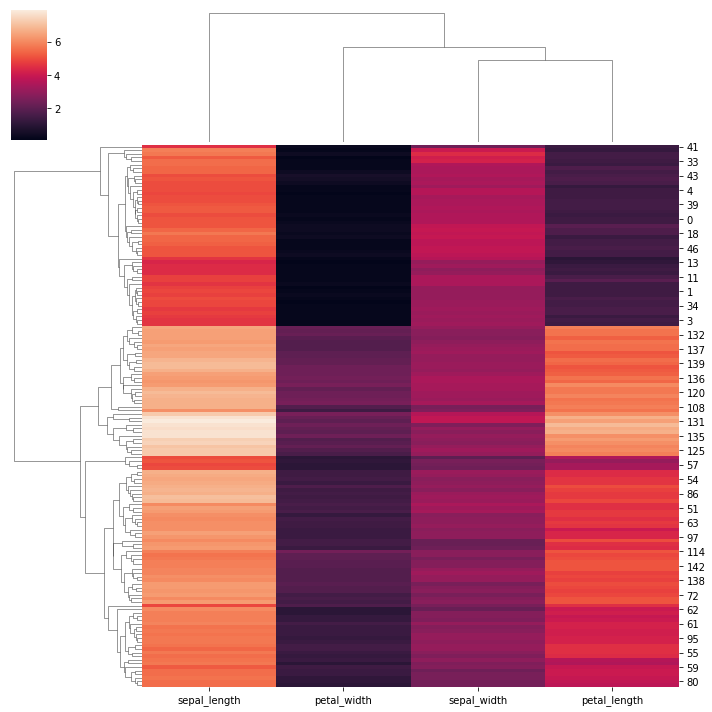

In [26]:
iris = seaborn.load_dataset("iris")
species = iris.pop("species")
g = seaborn.clustermap(iris)
lut = dict(zip(species.unique(), "rbg"))

In [27]:
deg_colors = total[['ENTREZID', 'logFC']]
deg_colors['ENTREZID'] = [str(k) for k in deg_colors['ENTREZID']]
deg_colors = deg_colors.set_index('ENTREZID')

colors = list(seaborn.color_palette('coolwarm_r', n_colors=500))
colors = colors[:60] + colors[-60:]
colors_lut = dict(zip(list(deg_colors.index), colors))
deg_colors['DiffExpression'] = [colors_lut[k] for k in list(deg_colors.index)]

deg_colors = deg_colors[['DiffExpression']]
deg_colors

<ipython-input-27-22b8710317d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deg_colors['ENTREZID'] = [str(k) for k in deg_colors['ENTREZID']]


,DiffExpression
ENTREZID,
6382,"(0.705673158, 0.01555616, 0.150232812)"
3512,"(0.7115538514588235, 0.0333368542117647, 0.154..."
7345,"(0.7115538514588235, 0.0333368542117647, 0.154..."
2731,"(0.717434544917647, 0.05111754842352941, 0.158..."
3429,"(0.717434544917647, 0.05111754842352941, 0.158..."
...,...
6441,"(0.2389484589019608, 0.3123654946588235, 0.765..."
9148,"(0.2389484589019608, 0.3123654946588235, 0.765..."
7380,"(0.2343770794509804, 0.3055417303294118, 0.759..."


<Figure size 432x288 with 0 Axes>

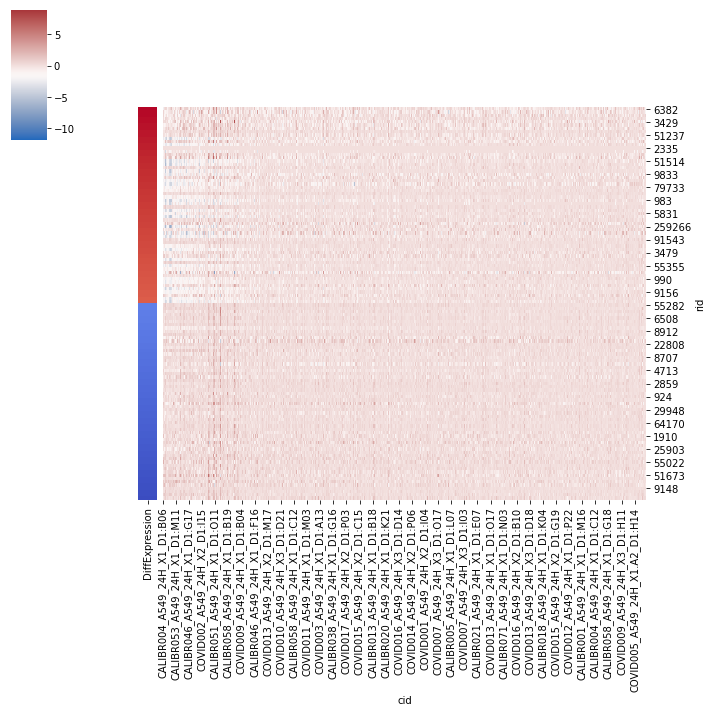

In [28]:
plt.clf()
seaborn.clustermap(sb2_prio, cmap='vlag', col_cluster=False, row_cluster=False, row_colors=deg_colors)
plt.savefig('outputs/overview.png')

C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

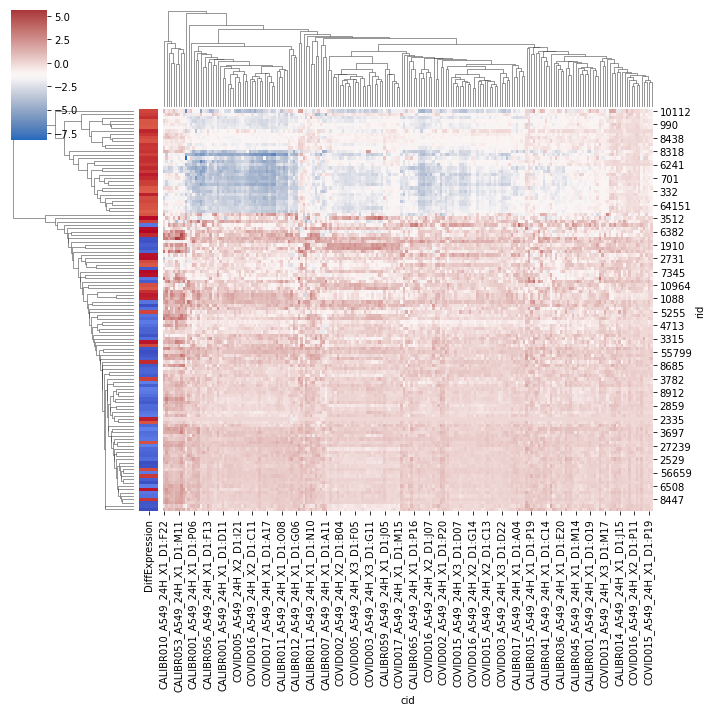

In [29]:
sb2_top200 = sb2_prio.iloc[:, :200]
plt.clf()
fig = seaborn.clustermap(sb2_top200, cmap='vlag', row_colors=deg_colors)
#fig = fig.get_figure()
fig.savefig('outputs/top200.png')

<Figure size 432x288 with 0 Axes>

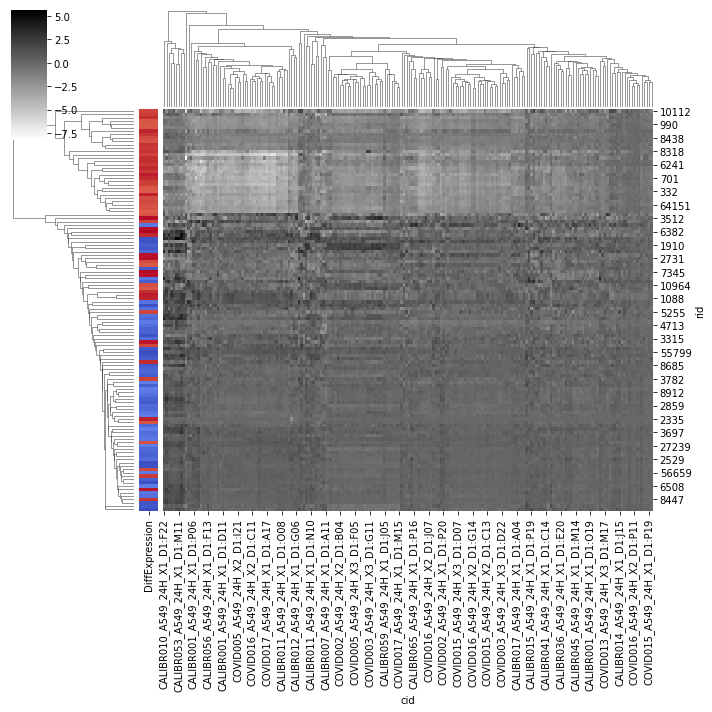

In [31]:
sb2_top200 = sb2_prio.iloc[:, :200]
plt.clf()
fig = seaborn.clustermap(sb2_top200, cmap='binary', row_colors=deg_colors)
#fig = fig.get_figure()
fig.savefig('outputs/top200_B&W.png')